# Shallow water model figures

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import torch
import torch.nn as nn

from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from os.path import join
from scipy.stats import binom

import sys
sys.path.append(os.getcwd() + "/../")
from gatsbi.task_utils.shallow_water_model import Simulator, Generator
from gatsbi.networks import WrapGenMultipleSimulations

# Calibration measures

In [2]:
from copy import deepcopy
from tabulate import tabulate

## Download data from WANDB
And put them in dataframes

In [3]:
from utils import obtain_wandb_data

In [4]:
runs_list, runs_list_GAN, runs_list_SRs = obtain_wandb_data(["shallow_water"])

For the moment I still do not have the GAN with 100k

In [5]:
runs_list = runs_list[0].sort_values("name")

In [6]:
runs_list.columns

Index(['name', 'ID', 'epochs', 'patch_size', 'patch_step', 'patched_sr',
       'sample_seed', 'gen_opt_args', 'path_to_data', 'scoring_rule',
       'hold_out_perc', 'log_dataloader', 'batch_size_perc',
       'num_training_simulations', 'num_simulations_generator', '_step',
       '_wandb', 'r2_val_mean', 'cal_err_val_mean', 'early_stop_at_epoch',
       '_timestamp', 'global_step', 'rmse_val_mean', 'kernel_bandwidth',
       '_runtime', 'gen_loss', 'sbc_lines', 'r2_val_std', 'train_time',
       'rmse_val_std', 'cal_err_val_std', 'gen_grad'],
      dtype='object')

In [7]:
runs_list

,name,ID,epochs,patch_size,patch_step,patched_sr,sample_seed,gen_opt_args,path_to_data,scoring_rule,...,rmse_val_mean,kernel_bandwidth,_runtime,gen_loss,sbc_lines,r2_val_std,train_time,rmse_val_std,cal_err_val_std,gen_grad
4,shallow_water_model_energy_score_10,1few29re,40000,NaN,NaN,False,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,energy_score,...,0.052618,NaN,51328,18.685009,"{'_type': 'image-file', 'width': 800, 'format'...",0.052901,49578.983311,0.010630,0.024071,NaN
5,shallow_water_model_energy_score_10_patched_10_20,1561o16q,40000,20.0,10.0,True,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,energy_score,...,0.050087,NaN,60017,21.508589,{'sha256': '7031ebd3476e76b8367c7150231a0061ef...,0.053067,58268.106747,0.010817,0.021912,NaN
2,shallow_water_model_energy_score_10_patched_5_10,3egmos85,40000,10.0,5.0,True,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,energy_score,...,0.055171,NaN,49626,22.369352,"{'format': 'png', 'height': 500, 'sha256': '97...",0.058443,47821.989587,0.011099,0.024239,NaN
3,shallow_water_model_kernel_score_10,2uxbmhcg,40000,NaN,NaN,False,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,kernel_score,...,0.060144,53.253471,39608,-0.913064,"{'_type': 'image-file', 'width': 800, 'format'...",0.056501,37836.248429,0.010678,0.046723,NaN
0,shallow_water_model_kernel_score_10_patched_10_20,3pa43rv9,40000,20.0,10.0,True,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,kernel_score,...,0.056381,53.253471,47642,-1.023466,{'sha256': 'd5cd40bc938ac9bb62af4f50b0a953c218...,0.059489,45889.404201,0.011138,0.044335,NaN
1,shallow_water_model_kernel_score_10_patched_5_10,11c1d2t1,40000,10.0,5.0,True,42,"[0.0001, [0.9, 0.99]]",./shallow_water_data_larger/,kernel_score,...,0.055980,53.253471,44590,-0.970579,{'sha256': '1c0d352da456b52c13f8fdaf05fbc648b4...,0.055840,42793.053084,0.010563,0.044367,NaN


## Now print all results as Table

In [8]:
def print_table(df, latex=False, file=None, tranpose=False):

    metrics = [['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
                   ['r2_val_std', 'r2_val_mean'], ['_runtime'], ['global_step']]
    metric_names = [r"NRMSE $ \downarrow $", r"Cal. Err. $ \downarrow $", r"R$^2$ $ \uparrow $", "Runtime (sec)", "Early stopping epoch"]
    
    df_dict = df.to_dict("list")
    
    name_list = [""] + [name.replace("shallow_water_model_", "").replace("_", " ").replace("score", "") for name in df_dict["name"]]
    
    all_lists = []
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    

        if len(metric) == 2:
            inner_list += [f"{df_dict[metric[1]][i]:.2f} $\pm$ {df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
        else:
            inner_list += [f"{df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
                
        all_lists.append(deepcopy(inner_list))

    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow"))
    else:
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow"))

In [9]:
print_table(runs_list, file=f"tables/shallow_water_model_all_metrics_n_gen={10}", latex=True, tranpose=True)

Print a Table with only the best performing method:

GAN results are missing here; I add them below.

In [10]:
runs_selected = runs_list[runs_list["name"].isin(["shallow_water_model_energy_score_10_patched_10_20"])]
print_table(runs_selected, file=f"tables/shallow_water_model_best_methods_all_metrics_n_gen={10}", latex=True, tranpose=True)

# Calibration metrics for the GATSBI trained net
We were given the trained net by the author of the original paper (Ramesh); therefore, we use it here to compute the posterior calibration metrics we have added. 

In [11]:
gen = Generator()

chpt = torch.load("plotting_data/shallow_water_chpt_sw_model.pt", map_location=torch.device('cpu') )
gen.load_state_dict(chpt["gen_state_dict"])

<All keys matched successfully>

In [12]:
import importlib, yaml
task_name = "shallow_water_model"

application = importlib.import_module("gatsbi.task_utils.%s" % task_name)

from argparse import Namespace as NSp

with open(join("..", "tasks", task_name, "defaults.yaml"), "r") as f:
    defaults = yaml.load(f, Loader=yaml.Loader)#
config = NSp(**defaults)

batch_size = min(1000, int(config.batch_size_perc * config.num_simulations))

In [13]:
# That relies on data generated using the sample_shallow_water.py script.
test_theta, test_obs = application.get_dataloader(
    batch_size, 0, "../"+config.path_to_data, test=True, return_data=True
)

Running the one below takes a lot of time. You can directly load the stored data with the cell immediately below

Generating simulations from the generative network...


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


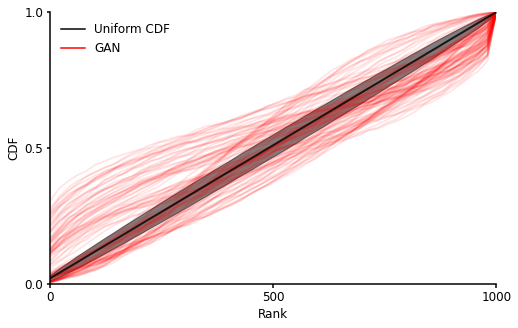

In [14]:
from gatsbi.utils import compute_calibration_metrics, generate_test_set_for_calibration_from_obs

test_theta_fake, test_theta = generate_test_set_for_calibration_from_obs(test_theta, test_obs, gen,
                                                                         n_test_samples=1000,
                                                                         n_generator_simulations=1000,
                                                                         batch_size=100,
                                                                         data_is_image=False)

fig_filename = join("..", "results", task_name) + "/GAN_" + str(defaults["num_simulations"])
    
res = compute_calibration_metrics(test_theta_fake, test_theta, sbc_lines=True,
                                  norm_rmse=task_name != "camera_model",
                                  sbc_lines_kwargs={"name": "GAN",
                                              "filename": fig_filename + "_sbc_lines.pdf"},
                            sbc_hist_kwargs={"filename": fig_filename + "_sbc_hist.pdf"})
a_file = open("plotting_data/shallow_water_model_calibration_metrics.pkl", "wb")
pickle.dump(res, a_file)
a_file.close()

In [15]:
a_file = open("plotting_data/shallow_water_model_calibration_metrics.pkl", "rb")

output = pickle.load(a_file)

print(output)

{'cal_err_val_mean': 0.12405999999999999, 'r2_val_mean': 0.7754172829064371, 'rmse_val_mean': 0.070920005, 'cal_err_val_std': 0.08507406420290499, 'r2_val_std': 0.05226571384472461, 'rmse_val_std': 0.0103552025, 'sbc_lines': <wandb.sdk.data_types.Image object at 0x7f03ec158910>}


In [16]:
def single_line_table(dictionary, latex=False, file=None):

    metrics = [['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
                   ['r2_val_std', 'r2_val_mean']]
    
    table = []
    
    for metric in metrics: 
        if len(metric) == 2:
            table.append(f"{dictionary[metric[1]]:.2f} $\pm$ {dictionary[metric[0]]:.2f}")
        else:
            table.append(f"{dictionary[metric[0]]:.2f}")
    table = [table]
    
    if file is None:
        if latex: 
            print(tabulate(table, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(table, headers="firstrow"))
    else:
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(table, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(table, headers="firstrow"))

In [17]:
single_line_table(res, latex=True)

\begin{tabular}{}
\hline
 0.07 $\pm$ 0.01   & 0.12 $\pm$ 0.09   & 0.78 $\pm$ 0.05   \\
\hline
\hline
\end{tabular}


Now add those results in the Latex tables; that does not work if I did not use transpose_table=True above. 

# Load the original data accompanying the GATSBI paper

In [18]:
shallow_water_data = np.load("plotting_data/shallow_water_data.npz", allow_pickle=True)

In [19]:
methods = ["groundtruth", "gatsbi", "npe", "nre"]
post_samples = shallow_water_data["posterior_samples"].tolist()
z_samples = shallow_water_data["posterior_predictive_samples"].tolist()
prior_samples = shallow_water_data["prior_samples"]
prior_z_samples = shallow_water_data["prior_predictive_samples"]
ranks_sbc = shallow_water_data["ranks_sbc"].tolist()

Notice: need to transpose the prior samples in order for the plots below to make sense!

In [20]:
prior_samples = prior_samples.T

In [21]:
post_samples.keys()

dict_keys(['groundtruth', 'gatsbi', 'npe', 'nle'])

# Original figure

/tmp/ipykernel_888332/3852860418.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  sample = post_samples[method].squeeze().T
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


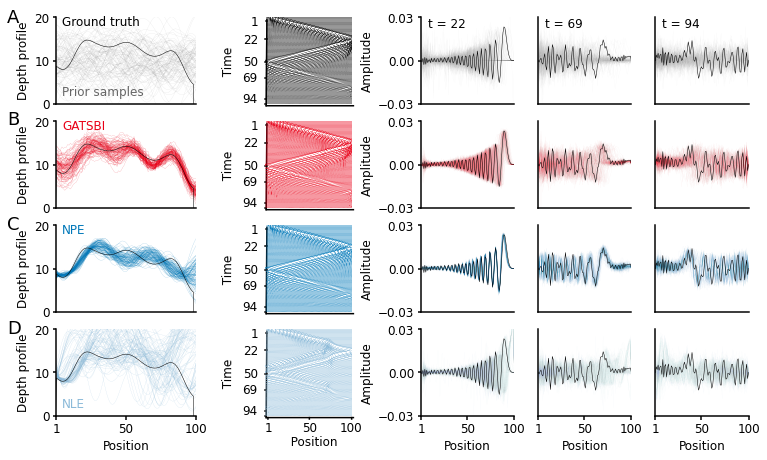

In [22]:
fig = plt.figure(
    figsize=(8.27*1.5, 5.5+1.83),
)
fig.tight_layout(pad=3.0)

widths  = [3, 3.8, 2, 2, 2]
heights = [3, 3, 3, 3]

methods = ["groundtruth", "gatsbi", "npe", "nle"]
assert len(heights) == len(methods)

timepoints = [22, 69, 94]
xlim = [1, 100]
xticks = [1, 50, 100]
colors = {"groundtruth": "k", "gatsbi": "#E90017", "npe": "#0078B9", "nre": "#78ADD1", "nle": "#8BBAD9"}
line_alpha = 0.95
line_width = 0.1
line_width_bigger = 0.5

label_x = "Position"  # "x-distance"
label_y = "Time"
label_z = "Amplitude"  # "Height"
label_theta = "Depth profile"

nrows = len(heights)
ncols = len(widths)
spec = fig.add_gridspec(
    ncols=ncols, 
    nrows=nrows, 
    width_ratios=widths, 
    height_ratios=heights)


def plot_params(ax, method, hide_x=False):
    sample = post_samples[method].squeeze().T
    gt = post_samples["groundtruth"].squeeze().T

    if method != "groundtruth":
        ax.plot(np.arange(100)+1.,
                sample,
                color=colors[method], 
                lw=line_width,
                alpha=line_alpha,
                label="")
        
    else:
        ax.plot(np.arange(100)+1.,
                prior_samples,
                color="grey", 
                lw=line_width,
                alpha=0.5,
                label="")

    ax.plot(gt,
            color=colors["groundtruth"], 
            lw=line_width_bigger,
            alpha=1.)
    
    if method == "groundtruth":
        ax.text(5, 18, f"Ground truth", fontsize=12, color=colors[method])
        ax.text(5, 2, "Prior samples", fontsize=12, color="#666")
    else:
        if method != "nle":
            ax.text(5, 18, f"{method.upper()}", fontsize=12, color=colors[method])
        else:
            ax.text(5, 2, f"{method.upper()}", fontsize=12, color=colors[method])
            
    ax.set_xlim(xlim) 
    ax.set_xticks(xticks)
    
    ax.set_ylim([0., +20])
    ax.set_yticks([0., 10., +20])
    ax.set_ylabel(label_theta)
    
    if hide_x:
        ax.set_xticks([])
    else:
        ax.set_xlabel(label_x)
    
    return ax


def plot_waves(ax, method, hide_x=False):
    sample = z_samples[method]
    
    ax.view_init(85,89.9999)  # Note: For 85, 90 axes will swap to other side

    for w in range(100):
        x = np.linspace(1, 100, 100)  # 1 ... 100
        y = np.ones(x.size)  # 1 ... 1
        z = sample[0][w, :]
        ax.plot3D(x, (w + 1) * y, z, lw=0.4, color=colors[method])

    ax.set_aspect('auto')

    # Ticks and labels
    xlabel = f"  {label_x}"
    ylabel = f"  {label_y}"
    xticks = [1, 50, 100]
    yticks = [1, 22, 50, 69, 94, 100]  # 1, 50, 100
    zticks = []
    ax.set_xlim(xlim) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, va='bottom', ha='center')
    ax.set_xlabel(xlabel, va='bottom') #, fontsize=45)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["1", "22", "50", "69", "94", ""], va='center', ha='right')
    ax.set_ylabel(ylabel, rotation=90, va='top', ha='right') #, fontsize=45)    
    ax.set_ylim([1,100])
    ax.set_zticks(zticks)
    ax.set_zlabel('')
                   
    # Invert axes
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    # Remove background
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Set zoom
    ax.dist = 6
    
    # Remove grid
    ax.grid(False)
    
    # Remove z-axis
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])    
    
    # Additional tick adjustments
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', direction='out')
    ax.tick_params(axis='z', direction='out')
    ax.tick_params(axis='x', which='major', pad=1)
    ax.tick_params(axis='y', which='major', pad=-3)
    ax.xaxis._axinfo['label']['space_factor'] = 0.8
    ax.yaxis._axinfo['label']['space_factor'] = 0.8    
    ax.xaxis.labelpad = -8.
    ax.yaxis.labelpad = +2.
    #ax.xaxis._axinfo['tick']['inward_factor'] = 0.
    #ax.yaxis._axinfo['tick']['inward_factor'] = 0.
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.
    
    #print(ax.xaxis._axinfo['tick'])
    #print(ax.xaxis._axinfo['label'])
    
    if hide_x:
        ax.set_xlabel("")
        ax.set_xticks([])

    return ax


def plot_waves_zoom_in(ax, method, timeval, hide_t=False, hide_x=False, hide_y=False):
    if method != "groundtruth":
        sample = z_samples[method][:, timeval, :]
        ax.plot(np.arange(100)+1, sample.T, alpha=0.1, color=colors[method], lw=line_width)
    else:
        ax.plot(np.arange(100)+1, prior_z_samples[:, timeval, :].T, alpha=0.1, color="grey", lw=line_width)
    
    gt = z_samples["groundtruth"][0, timeval, :]
    ax.plot(np.arange(100)+1, gt, color=colors["groundtruth"], lw=line_width_bigger)
    
    if not hide_t:
        ax.text(8, 0.023, f"t = {timeval}", fontsize=12)
    
    ax.set_xlim(xlim) 
    if not hide_x:
        ax.set_xticks(xticks)
        ax.set_xlabel(label_x)    
    else:
        ax.set_xticks([])
    
    ax.set_ylim([-0.03, +0.03])
    if not hide_y:
        ax.set_ylabel(label_z)
        ax.set_yticks([-0.03, 0., +0.03])
    else:
        ax.set_yticks([])
        
    return ax


with mpl.rc_context(fname='./matplotlibrc'):
    for row in range(nrows):
        for col in range(ncols):        
            if col == 0:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_params(
                    ax, 
                    methods[row], 
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col == 1:
                ax = fig.add_subplot(spec[row, col], projection='3d')
                ax = plot_waves(
                    ax, 
                    methods[row],
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col > 1:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_waves_zoom_in(
                    ax, 
                    methods[row], 
                    timepoints[col-2],
                    hide_t=True if row != 0 else False,
                    hide_y=True if col > 2 else False,
                    hide_x=True if row != (nrows-1) else False,
                )

    # Note: These positions might look bad in the preview but turn out well on pdf export
    panel_x = 0.07
    fig.text(panel_x, .87, "A", fontsize=18)
    fig.text(panel_x, .676, "B", fontsize=18)
    fig.text(panel_x, .478, "C", fontsize=18)
    fig.text(panel_x, .280, "D", fontsize=18)
    
    #plt.savefig("plots/Figure3.pdf")

# Figures for other methods 
## Observation

The following contains the observation (i.e. solution of the PDE) transformed to Fourier space and summed to noise. 

If you want to obtain an alternative observation, you can do it following the following steps: 

In [23]:
from scipy.fft import fft2
def observation_noise(
    observation,
    seed = 42,
    gain = 1,
    scale = 0.25,
):
    """
    Add white noise to observations.

    Args:
        observation: simulation to which to add noise.
        seed: random-sampling seed.
        gain: gain value to scale up observation values.
        scale: std of white noise.
    """
    np.random.seed(seed)
    return gain * (observation) + (scale * np.random.randn(*observation.shape))

In [24]:
z = z_samples["groundtruth"][0]
fft_z_real = np.expand_dims(fft2(z).real, 0)
fft_z_imag = np.expand_dims(fft2(z).imag, 0)
z = np.concatenate([fft_z_real, fft_z_imag], 0)

# add observation noise
z = observation_noise(z)

In [25]:
z.shape

(2, 100, 100)

Load the observation used to produce the posterior plot in the original paper: 

>In `test_plot_sample.npz`, there are 3 variables: (1) `depth_profile`: groundtruth depth_profile (2) `z_surface_height`: the surface wave height observations corresponding to this depth profile (3) `z_val`: the Fourier transformed surface wave heights that are input to the GATSBI generator to get posterior samples.

In [26]:
original_observation = np.load("plotting_data/shallow_water_test_plot_sample.npz")

In [27]:
z = original_observation["z_val"][0]
print(z.shape)

(2, 100, 100)


## Posterior samples

In [28]:
from glob import glob

In [29]:
!mkdir plots/shallow_water_model

mkdir: cannot create directory 'plots/shallow_water_model': File exists


In [30]:
root_folder = "/data/localhost/pacchiar/GATSBI_extension_res/"

Define the generator network and the simulator model; the latter needs to be instantiated with no Fourier transform and no added noise to the output in order to compare with the stored data. 

In [31]:
gen = Generator()
simulator = Simulator(fourier=False, scale=0)  # add no noise to simulator output

Transform observations to torch to feed to NN

In [32]:
obs_test_tensor = torch.from_numpy(z.astype(np.float32)).unsqueeze(0)
obs_test_tensor.shape

torch.Size([1, 2, 100, 100])

The following generates posterior samples and posterior predictive samples for all the SR methods.

**Notice**: Need to add 10 to the output of the NN before passing through the simulator as the depth profiles in training set were translated by -10.

In [33]:
n_post_samples = 100
task_name = "shallow_water_model"
df_in = runs_list

scoring_rule_list = ["energy_score", "kernel_score"]
patches_list = [None, [5,10], [10,20]]

my_names_list = []

for scoring_rule in scoring_rule_list:
    for patch in patches_list:

        # obtain the identifier
        df = df_in[df_in.scoring_rule == scoring_rule]
        if patch is None: 
            df = df[df.patched_sr == False]
        else:
            df = df[df.patched_sr== True]
            df = df[df.patch_size == patch[1]]         
            
        identifier = df["ID"].item()
        print(identifier)

        # obtain the path
        correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
        if len(correct_folder) == 0:
            print("No match")
            continue
        correct_folder = correct_folder[0]
        
        # now should load the generative network for that folder:        
        chpt = torch.load(correct_folder +  "/files/checkpoint_models0.pt",map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        # wrap the generator so that it can generate multiple samples at once: 
        gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)        
        
        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))
        my_names_list.append(name)
        
        # now feed the observations into the generator to obtain posterior samples: 
        # samples_list.append(gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10)  # translate up by 10
        post_samples[name] = gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10  # translate up by 10
        
        # now pass through the simulator to obtain posterior predictive samples: should not do any fourier transform either
        # simulations_list.append(np.array([simulator(sample.reshape(1,-1))[0] for sample in samples_list[-1]]).squeeze())
        z_samples[name] = np.array([simulator(sample.reshape(1,-1))[0] for sample in post_samples[name]]).squeeze()
        
        #break
    #break

1few29re
3egmos85
1561o16q
2uxbmhcg
11c1d2t1
3pa43rv9


In [34]:
z_samples[name].shape

(100, 101, 100)

In [35]:
z_samples['gatsbi'].shape

(100, 100, 100)

First dimension of simulation is larger than what stored in the plot data by 1. We need therefore to discard the initial time-step: 

In [36]:
for scoring_rule in scoring_rule_list:
    for patch in patches_list:
        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))

        z_samples[name] = z_samples[name][:,1:,:]

Now compute posterior samples and simulations with my trained GATSBI. I have not trained with 100k samples now, so need to wait for the trained net to be sent to me.

    # obtain the identifier
    df = df_in[df_in.loss == "cross_entropy"]

    identifier = df["ID"].item()
    print(identifier)

    # obtain the path
    correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
    if len(correct_folder) == 0:
        print("No match")
    else:
        correct_folder = correct_folder[0]

        # now should load the generative network for that folder:        
        chpt = torch.load(correct_folder +  "/files/checkpoint_models0.pt",map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        # wrap the generator so that it can generate multiple samples at once: 
        gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)        

        name = "GATSBI_mine"
        my_names_list.append(name)

        # now feed the observations into the generator to obtain posterior samples: 
        # samples_list.append(gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10)  # translate up by 10
        post_samples[name] = gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10  # translate up by 10

        # now pass through the simulator to obtain posterior predictive samples: should not do any fourier transform either
        # simulations_list.append(np.array([simulator(sample.reshape(1,-1))[0] for sample in samples_list[-1]]).squeeze())
        z_samples[name] = np.array([simulator(sample.reshape(1,-1))[0] for sample in post_samples[name]]).squeeze()

## Plots

### First: plot with my best method alongside the others

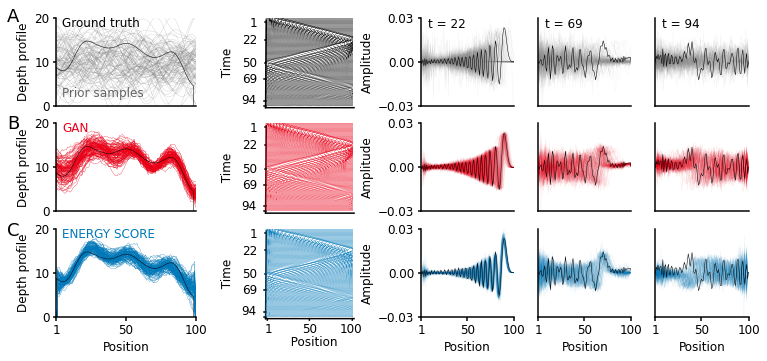

In [37]:
widths  = [3, 3.8, 2, 2, 2]

# methods = ["groundtruth", "gatsbi", "npe", "nle"]
methods = ["groundtruth", "gatsbi", "npe", "energy_score10_20"]
method_names = ["groundtruth", "gan", "npe", "Energy Score"]
methods = ["groundtruth", "gatsbi", "energy_score10_20"]
method_names = ["groundtruth", "gan", "Energy Score"]
heights = [3] * len(methods)
assert len(heights) == len(methods)

fig = plt.figure(
    figsize=(8.27*1.5, (5.5+1.83) * len(methods) / 4),
)
fig.tight_layout(pad=3.0)

timepoints = [22, 69, 94]
xlim = [1, 100]
xticks = [1, 50, 100]
colors = {"groundtruth": "k", 
          "gatsbi": "#E90017", 
          "npe": "#0078B9", 
          "nre": "#78ADD1", 
          "nle": "#8BBAD9"}
colors.update({name: "#0078B9" for name in my_names_list})  # add my methods

line_alpha = 0.95
line_width = 0.3
line_width_bigger = 0.5

label_x = "Position"  # "x-distance"
label_y = "Time"
label_z = "Amplitude"  # "Height"
label_theta = "Depth profile"

nrows = len(heights)
ncols = len(widths)
spec = fig.add_gridspec(
    ncols=ncols, 
    nrows=nrows, 
    width_ratios=widths, 
    height_ratios=heights)


def plot_params(ax, method, method_name, hide_x=False):
    sample = post_samples[method].squeeze().T
    gt = post_samples["groundtruth"].squeeze().T

    if method != "groundtruth":
        ax.plot(np.arange(100)+1.,
                sample,
                color=colors[method], 
                lw=line_width,
                alpha=line_alpha,
                label="")
        
    else:
        ax.plot(np.arange(100)+1.,
                prior_samples,
                color="grey", 
                lw=line_width,
                alpha=0.5,
                label="")

    ax.plot(gt,
            color=colors["groundtruth"], 
            lw=line_width_bigger,
            alpha=1.)
    
    if method_name == "groundtruth":
        ax.text(5, 18, f"Ground truth", fontsize=12, color=colors[method])
        ax.text(5, 2, "Prior samples", fontsize=12, color="#666")
    else:
        if method_name != "nle":  # here is where the text gets added
            ax.text(5, 18, f"{method_name.upper()}", fontsize=12, color=colors[method])
        else:
            ax.text(5, 2, f"{method_name.upper()}", fontsize=12, color=colors[method])
            
    ax.set_xlim(xlim) 
    ax.set_xticks(xticks)
    
    ax.set_ylim([0., +20])
    ax.set_yticks([0., 10., +20])
    ax.set_ylabel(label_theta)
    
    if hide_x:
        ax.set_xticks([])
    else:
        ax.set_xlabel(label_x)
    
    return ax


def plot_waves(ax, method, hide_x=False):
    sample = z_samples[method]
    
    ax.view_init(85,89.9999)  # Note: For 85, 90 axes will swap to other side

    for w in range(100):
        x = np.linspace(1, 100, 100)  # 1 ... 100
        y = np.ones(x.size)  # 1 ... 1
        z = sample[0][w, :]
        ax.plot3D(x, (w + 1) * y, z, lw=0.4, color=colors[method])

    ax.set_aspect('auto')

    # Ticks and labels
    xlabel = f"  {label_x}"
    ylabel = f"  {label_y}"
    xticks = [1, 50, 100]
    yticks = [1, 22, 50, 69, 94, 100]  # 1, 50, 100
    zticks = []
    ax.set_xlim(xlim) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, va='bottom', ha='center')
    ax.set_xlabel(xlabel, va='bottom') #, fontsize=45)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["1", "22", "50", "69", "94", ""], va='center', ha='right')
    ax.set_ylabel(ylabel, rotation=90, va='top', ha='right') #, fontsize=45)    
    ax.set_ylim([1,100])
    ax.set_zticks(zticks)
    ax.set_zlabel('')
                   
    # Invert axes
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    # Remove background
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Set zoom
    ax.dist = 6
    
    # Remove grid
    ax.grid(False)
    
    # Remove z-axis
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])    
    
    # Additional tick adjustments
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', direction='out')
    ax.tick_params(axis='z', direction='out')
    ax.tick_params(axis='x', which='major', pad=1)
    ax.tick_params(axis='y', which='major', pad=-3)
    ax.xaxis._axinfo['label']['space_factor'] = 0.8
    ax.yaxis._axinfo['label']['space_factor'] = 0.8    
    ax.xaxis.labelpad = -8.
    ax.yaxis.labelpad = +2.
    #ax.xaxis._axinfo['tick']['inward_factor'] = 0.
    #ax.yaxis._axinfo['tick']['inward_factor'] = 0.
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.
    
    #print(ax.xaxis._axinfo['tick'])
    #print(ax.xaxis._axinfo['label'])
    
    if hide_x:
        ax.set_xlabel("")
        ax.set_xticks([])

    return ax


def plot_waves_zoom_in(ax, method, timeval, hide_t=False, hide_x=False, hide_y=False):
    if method != "groundtruth":
        sample = z_samples[method][:, timeval, :]
        ax.plot(np.arange(100)+1, sample.T, alpha=0.1, color=colors[method], lw=line_width)
    else:
        ax.plot(np.arange(100)+1, prior_z_samples[:, timeval, :].T, alpha=0.1, color="grey", lw=line_width)
    
    gt = z_samples["groundtruth"][0, timeval, :]
    ax.plot(np.arange(100)+1, gt, color=colors["groundtruth"], lw=line_width_bigger)
    
    if not hide_t:
        ax.text(8, 0.023, f"t = {timeval}", fontsize=12)
    
    ax.set_xlim(xlim) 
    if not hide_x:
        ax.set_xticks(xticks)
        ax.set_xlabel(label_x)    
    else:
        ax.set_xticks([])
    
    ax.set_ylim([-0.03, +0.03])
    if not hide_y:
        ax.set_ylabel(label_z)
        ax.set_yticks([-0.03, 0., +0.03])
    else:
        ax.set_yticks([])
        
    return ax


with mpl.rc_context(fname='./matplotlibrc'):
    for row in range(nrows):
        for col in range(ncols):        
            if col == 0:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_params(
                    ax, 
                    methods[row], 
                    method_names[row], 
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col == 1:
                ax = fig.add_subplot(spec[row, col], projection='3d')
                ax = plot_waves(
                    ax, 
                    methods[row],
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col > 1:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_waves_zoom_in(
                    ax, 
                    methods[row], 
                    timepoints[col-2],
                    hide_t=True if row != 0 else False,
                    hide_y=True if col > 2 else False,
                    hide_x=True if row != (nrows-1) else False,
                )

    # Note: These positions might look bad in the preview but turn out well on pdf export
    panel_x = 0.07
    fig.text(panel_x, .87, "A", fontsize=18)
    fig.text(panel_x, .6, "B", fontsize=18)
    fig.text(panel_x, .33, "C", fontsize=18)
    #fig.text(panel_x, .280, "D", fontsize=18)
    
    plt.savefig("plots/shallow_water_model/shallow_water_model_best_methods.pdf")

### Second: plot for all of my methods alongside the others

In [38]:
[name.replace("score", "score ").replace("_", " ") for name in my_names_list]

['energy score ',
 'energy score 5 10',
 'energy score 10 20',
 'kernel score ',
 'kernel score 5 10',
 'kernel score 10 20']

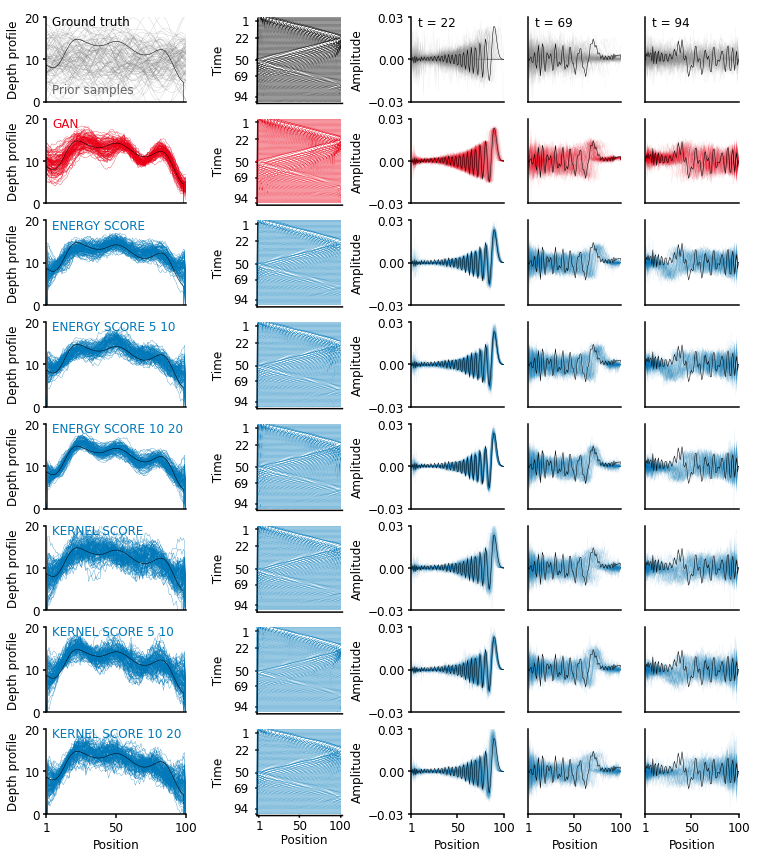

In [39]:
widths  = [3, 3.8, 2, 2, 2]

# methods = ["groundtruth", "gatsbi", "npe", "nle"]
#methods = ["groundtruth", "gatsbi", "npe"] + my_names_list
#method_names = ["groundtruth", "gan", "npe"] + [name.replace("score", "score ").replace("_", " ") for name in my_names_list]
methods = ["groundtruth", "gatsbi"] + my_names_list
method_names = ["groundtruth", "gan"] + [name.replace("score", "score ").replace("_", " ") for name in my_names_list]
heights = [3] * len(methods)
assert len(heights) == len(methods)

fig = plt.figure(
    figsize=(8.27*1.5, (5.5+1.83) * len(methods) / 4),
)
fig.tight_layout(pad=3.0)

timepoints = [22, 69, 94]
xlim = [1, 100]
xticks = [1, 50, 100]
colors = {"groundtruth": "k", 
          "gatsbi": "#E90017", 
          "npe": "#0078B9", 
          "nre": "#78ADD1", 
          "nle": "#8BBAD9"}
colors.update({name: "#0078B9" for name in my_names_list})  # add my methods

line_alpha = 0.95
line_width = 0.3
line_width_bigger = 0.5

label_x = "Position"  # "x-distance"
label_y = "Time"
label_z = "Amplitude"  # "Height"
label_theta = "Depth profile"

nrows = len(heights)
ncols = len(widths)
spec = fig.add_gridspec(
    ncols=ncols, 
    nrows=nrows, 
    width_ratios=widths, 
    height_ratios=heights)


with mpl.rc_context(fname='./matplotlibrc'):
    for row in range(nrows):
        for col in range(ncols):        
            if col == 0:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_params(
                    ax, 
                    methods[row], 
                    method_names[row], 
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col == 1:
                ax = fig.add_subplot(spec[row, col], projection='3d')
                ax = plot_waves(
                    ax, 
                    methods[row],
                    hide_x=True if row != (nrows-1) else False,
                )

            elif col > 1:
                ax = fig.add_subplot(spec[row, col])
                ax = plot_waves_zoom_in(
                    ax, 
                    methods[row], 
                    timepoints[col-2],
                    hide_t=True if row != 0 else False,
                    hide_y=True if col > 2 else False,
                    hide_x=True if row != (nrows-1) else False,
                )

    # Note: These positions might look bad in the preview but turn out well on pdf export
    panel_x = 0.07
    
    plt.savefig("plots/shallow_water_model/shallow_water_model_all_methods.pdf")

Closer look:

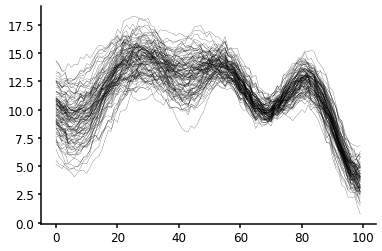

In [40]:
_ = plt.plot(post_samples["gatsbi"].T, color="k", alpha=1, lw=0.2)

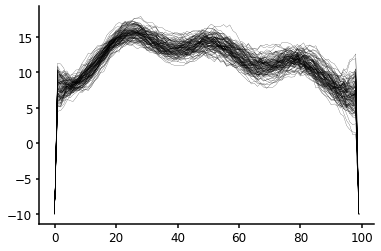

In [41]:
_ = plt.plot(post_samples["energy_score10_20"].T, color="k", alpha=1, lw=0.2)

# How to generate simulator outputs from GATSBI samples
I left this just for ease of reproducibility

In [42]:
def single_plot(sample):

    fig = plt.figure(
        figsize=(4,4),
    )
    ax = fig.add_subplot(1,1,1, projection='3d')

    ax.view_init(85,89.9999)  # Note: For 85, 90 axes will swap to other side

    for w in range(100):
        x = np.linspace(1, 100, 100)  # 1 ... 100
        y = np.ones(x.size)  # 1 ... 1
        z = sample[w, :]
        ax.plot3D(x, (w + 1) * y, z, lw=0.4, color="k")

    ax.set_aspect('auto')


    # Ticks and labels
    xlabel = f"  {label_x}"
    ylabel = f"  {label_y}"
    xticks = [1, 50, 100]
    yticks = [1, 22, 50, 69, 94, 100]  # 1, 50, 100
    zticks = []
    ax.set_xlim(xlim) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, va='bottom', ha='center')
    ax.set_xlabel(xlabel, va='bottom') #, fontsize=45)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["1", "22", "50", "69", "94", ""], va='center', ha='right')
    ax.set_ylabel(ylabel, rotation=90, va='top', ha='right') #, fontsize=45)    
    ax.set_ylim([1,100])
    ax.set_zticks(zticks)
    ax.set_zlabel('')

    # Invert axes
    ax.invert_xaxis()
    ax.invert_yaxis()

    # Remove background
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Set zoom
    ax.dist = 6

    # Remove grid
    ax.grid(False)

    # Remove z-axis
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])    

    # Additional tick adjustments
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', direction='out')
    ax.tick_params(axis='z', direction='out')
    ax.tick_params(axis='x', which='major', pad=1)
    ax.tick_params(axis='y', which='major', pad=-3)
    ax.xaxis._axinfo['label']['space_factor'] = 0.8
    ax.yaxis._axinfo['label']['space_factor'] = 0.8    
    ax.xaxis.labelpad = -8.
    ax.yaxis.labelpad = +2.
    #ax.xaxis._axinfo['tick']['inward_factor'] = 0.
    #ax.yaxis._axinfo['tick']['inward_factor'] = 0.
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.

    #print(ax.xaxis._axinfo['tick'])
    #print(ax.xaxis._axinfo['label'])


In [43]:
post_samples["gatsbi"].shape

(100, 100)

In [44]:
simulations_gatsbi = np.array([simulator(sample.reshape(1,-1))[0] for sample in post_samples["gatsbi"]]).squeeze()

In [45]:
sample = post_samples["gatsbi"][0]
z = simulator(sample.reshape(1,-1))[0]

In [46]:
z.shape

(1, 101, 100)

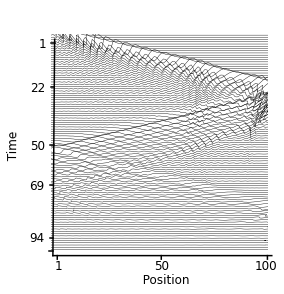

In [47]:
single_plot(z[0])